In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# adjust 한글 font
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# Chapter 5. Ensemble

## 5-1 Model Ensemble
- 여러 모델을 이용하여 데이터를 학습하고, 모든 모델의 예측결과를 평균하여 예측
- 앙상블 모델을 보통 지도학습에 사용
- 군집화난 학습데이터가 없는 outlier detection, anomaly detection, clustering 등에는 쓰기 어려움
- Why Ensemble?
    - Error 최소화
        - 다양한 모델의 결과를 종합, 오류를 감소
    - Overfitting 감소
        - bias : 편향, 예측값과 실제값의 차이
        - 모델별 다양한 bias를 종합하여 결과를 생성
    - Low Bias, High Variance
        - Variance를 줄이기 위한 기법

### Bias-Variance Trade off
- 출처 : https://datacookbook.kr/48
- Bias : [Error due to Bias]
    - bias로 인한 에러는 예측값과 실제값 간의 차이
    - 모델 학습시 여러 데이터를 사용하고, 반복하여 새로운 모델로 학습하면 예측값들의 범위를 확인 가능
    - **bias는 이 예측값들의 범위가 정답과 얼마나 멀리있는지 측정**
- Variance : [Error due to Variance]
    - 주어진 데이터로 학습한 모델이 예측한 값의 변동성
    - 만약 여러 모델로 학습을 반복한다고 가정하면,
    - **Variance는 학습된 모델별로 예측한 값들의 차이를 측정**
![title](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile9.uf.tistory.com%2Fimage%2F99CDCC33599AC28F075E3C)

### 수학적 정의 및 예시
- $Y$ : 예측값
- $X$ : 변수
- $\epsilon$ : 에러, 에러의 분포는 정규분포 $\epsilon\sim N(0, \sigma_\epsilon)$
- $Y\,=\,f(X)\,+\,\epsilon$ : 예측값과 변수간의 관계 ($f(X)$는 정답을 추출하는 함수)
- $\hat{f}(X)$ : 모델 학습을 통해 정답을 예측하는 함수
- 예측 모델의 에러 :
$$Err(x) = E\bigg[\big(Y-\hat{f}(x)\big)^{2}\bigg]$$
- 위 공식을 세분화하면 bias와 variance로 구성된 공식을 반환
$$Err(x) = \big(E[\hat{f}(x)]-f(x)\big)^{2}+E\bigg[\big(\hat{f}(x)-E[\hat{f}(x)]\big)^{2}\bigg]+\sigma_{\epsilon}^2$$
        - (정답과 예측값 간의 거리 측정) + (예측값과 예측값 평균간의 거리) + 에러
$$Err(x) = Bias^2 + Variance + Irreducible\,Error$$
        - Irreducible error : 어떤 모델로도 제거 불가능한 오류
        - 현실 세계에서는 완벽한 모델이 없기 때문에 제거할 수 없는 오류가 있다는 가정
        
### KNN으로 이해해보는 Trade-off 관계
- 유권자들이 어떤 정당을 투표할 지 예측
- K : 몇 개의 sample을 보고 분류할 지 결정
- K 증가
    - 각 예측에 더 많은 유권자 정보의 평균값 사용
    - 따라서, 예측곡선이 부드러워 짐
- K 감소
    - 1인 경우, 가장 가까운 유권자 정보만 고려하여,
    - 정당별로 고립되거나 급격한 예측곡선 생성
- [Variance 관점]
    - Small K $\rightarrow$ variance 증가
        - 가장 가까운 데이터 값을 이용하여 예측
        - 신규 데이터가 추가되면, 학습한 모델의 예측값이 급격히 변화
        - 즉, 모델간의 예측값 차이가 커짐
    - Large K $\rightarrow$ variance 감소
        - 여러 개(K)의 학습 데이터를 이용하여 예측
        - 신규 데이터가 추가되어도 예측값 간에 큰 차이 없음
- [Bias 관점]
    - Small K $\rightarrow$ Bias 감소
        - 가장 가까운 데이터 값을 이용하여 예측
        - 예측값이 정답과 근처에 있을 가능성 높음
    - Large K $\rightarrow$ Bias 증가
        - 모델선형 주변으로 예측하지 못하는 데이터가 많아짐
        - 예측값과 정답간의 거리가 멀어짐

### Basic concepts of Meta Learning
- **배깅(Bagging)**
    - bootstrap aggregation
- **스태킹(Stacking)**
    - 최종 결정 모델 훈련에 일부 모델의 예측만을 사용
        - 조합함수를 조ㅈ가하는 기법
- **보팅(Voting)**
    - 각각 분류기의 결과를 조합해서 최종 하나의 결과를 뽑는 논리
    - hard voting, soft voting
- **부스팅(Boosting)**
    - weak learner로 잘못 분류된 경우의 가중치를 증가시켜서 점차 분류해가는 기법

## 5-2 Bagging

### Bootstrap Aggregation
- 원 데이터 집합으로부터 크기가 같은 표본을 여러 번 _단순임의 복원 추출_하여 각 표본에 대해 분류기를 생성, 그 결과를 ensemble하는 기법
- 반복추출 방법을 사용하기 때문에 같은 데이터가 한 표본에 여러 번 추출될 수도 있고, 어떤 데이터는 추출되지 않을 수도 있다.
- 데이터가 충분히 큰 경우, 각 데이터가 하나의 부트스트랩 표본에서 제외될 확률은 36.78%이다.
$$\lim_{x \to \infty} \big(1-{{1}\over{n}}\big)^n=e^{-1}=0.3678$$

### Bagging의 개념
- 학습 데이터를 랜덤으로 샘플링하여 여러개의 bag으로 분할
- 각 bag별로 모델을 학습한 후, 결과를 합하여 최종 결과를 추출
- $n$ : 전체 학습 데이터 수
- $n^{`}$ : bag에 포함된 데이터 수, 전체 데이터 중 샘플된 데이터
- $m$ : bag의 갯수, 학습할 모델별로 샘플링된 데이터 셋
- 출처 : http://hugrypiggykim.com/2019/04/07/bagging-boosting-and-stacking/
<img src="https://i0.wp.com/hugrypiggykim.com/wp-content/uploads/2019/04/bagging2.png?resize=1024%2C526" width="400" height="300">

### 어떻게 예측정확도를 높이나?
- 출처 : https://www.youtube.com/watch?v=sVriC_Ys2cw
- 영상에서 model1은 하나의 bag으로 학습된 모델이다.
- 각 모델별로 보면, 학습 데이터에 overfitting되어 테스트 데이터로 검증하면 예측성능이 낮다.(high variance)
- Bagging은 이렇게 weak model을 여러개 결합하여, 전체적으로 high variance $\rightarrow$ low variance로 변하면서 예측 성능을 향상시킨다.
- 영상을 보면 여러개 모델이 서로 보완하면서 예측한다.
- Bagging은 linear 모델에서는 잘 사용하지 않는다.

### Bagging Aggregation
- 상대적으로 간단한 앙상블
    - 입력데이터가 약간씩 변경되면서(bootstrapping) Model들이 상당히 변함
    - 따라서 입력데이터의 "작은 변화 $\rightarrow$ 큰 변화"가 생기는 DT에 주로 사용
    - 또한 Bootstrapping할 때, 여러 기법이 가능하지만 보통 10 fold CV를 선호

### 단일 결정 트리와 500개 트리로 만든 배깅 앙상블 비교
- 출처 : HandsOn Machine Learning

In [481]:
print('단일 및 Voting 분류기 정확도 \n')
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='lbfgs', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

print('< voting 1 (voting=hard) >')
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

print('\n< voting 2 (voting=soft) >')
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

단일 및 Voting 분류기 정확도 

< voting 1 (voting=hard) >
LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896

< voting 2 (voting=soft) >
LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


In [482]:
print('Bagging 및 Tree 정확도\n')
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(tree_clf.__class__.__name__, accuracy_score(y_test, y_pred_tree))

Bagging 및 Tree 정확도

BaggingClassifier 0.904
DecisionTreeClassifier 0.856


#### 시각화

In [483]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

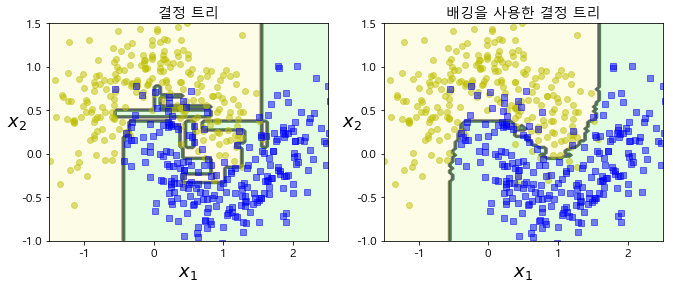

In [484]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

### 시각화 ZERO to MASTER

x1, x2's shape (100, 100) (100, 100)


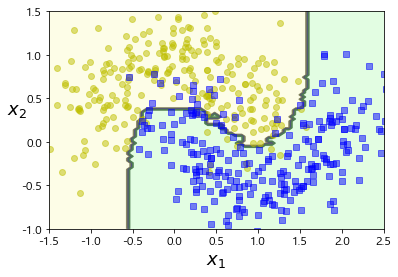

In [485]:
axes=[-1.5, 2.5, -1, 1.5]
alpha = .5
contour = True
# axes 만들기 밑바닥
# n=100
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
# 위의 상태로는 y=x 직선밖에 먼들지 못함
# 즉, numpy의 meshgrid함수를 사용하여 좌표체계를 만들어줌
x1, x2 = np.meshgrid(x1s, x2s)
print('x1, x2\'s shape', x1.shape, x2.shape)
# 결정경계 시각화를 위해 모든 좌표를 flatten시켜 X_new에 저장
X_new = np.c_[x1.ravel(), x2.ravel()]
# 이를 clf로 predict하여 label을 얻고 10,000*1을 100*100으로 reshape
y_pred = bag_clf.predict(X_new).reshape(x1.shape)
# list colormap을 호출, 이는 이산적인 라벨을 적용할 때 효과적
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
# 결정경계를 contourf로 그림. 이를 custom_cmap의 3가지 색상으로 시각화
plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
# contour가 True라면 더 선명하게하여 경계선을 그림
if contour:
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
# label별 점들을 시각화
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
# 축의 범위를 axes로 맞춰줌
plt.axis(axes)
# 라벨 설정 및 출력
plt.xlabel(r"$x_1$", fontsize=18)
plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
plt.show()

### 교재로 다시 Try

In [89]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print('bagging accuracy score :', accuracy_score(y_test, y_pred))

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Tree accuracy score :', accuracy_score(y_test, y_pred_tree))

bagging accuracy score : 0.92
Tree accuracy score : 0.872


### oob(out of bag) 평가
- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러번 sampling되고 어떤 것은 전혀 선택되지 않을 수 있음
- BaggingClassifier는 기본값으로 중복을 허용하여(`Bootstrap=True`) 훈련 세트의 크기 만큼인 m개 샘플을 선택
- 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미
- 선택되지 않은 훈련 샘플의 나머지 37%는 oob(out-of-bag) 샘플
- 예측기마다 남겨진 37%는 모두 다름
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지 않고 oob 샘플을 사용해 평가할 수 있음

In [90]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
        bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
print('oob score : {:4f}'.format(bag_clf.oob_score_))
y_pred = bag_clf.predict(X_test)
print('accuracy score :', accuracy_score(y_test, y_pred))

oob score : 0.933333
accuracy score : 0.904


### mglearn을 활용한 결정 경계 시각화

In [106]:
Xm, ym = make_moons(n_samples=100, noise=.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, stratify=ym, random_state=42)
bagging = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=5,
        n_jobs=-1, random_state=42)
bagging.fit(Xm_train, ym_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=5, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

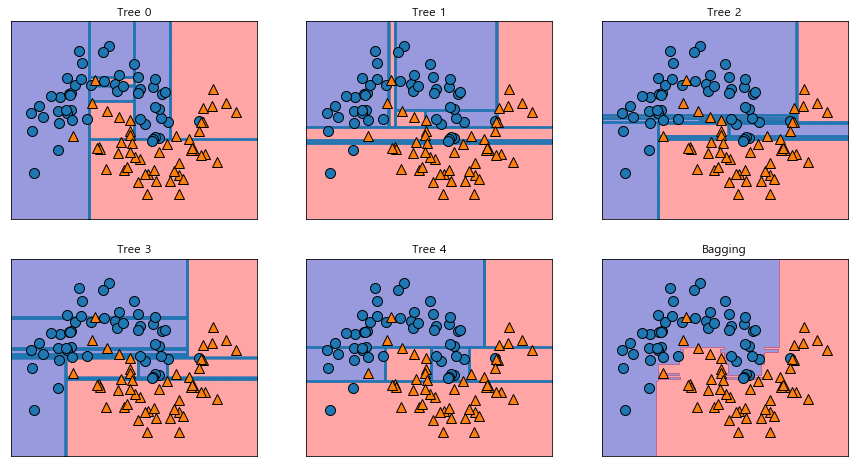

In [107]:
import mglearn
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# Bagging Tree의 각 estimator를 출력
for i, (ax, tree) in enumerate(zip(axes.ravel(), bagging.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
# Bagging Tree의 결정 경계를 출력
mglearn.plots.plot_2d_separator(bagging, Xm ,fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Bagging")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

### Random Forest
- Ensemble of DT
- 배깅한 Decision Tree
- DT에 다양성을 주기 위해
    - bagging
    - 무작위 속성 구분
    - voting
- 단일 Decision Tree의 문제점
    - train data에 overfitting
    - RF는 이를 회피하기 위해 만들어짐
- 각 tree는 예측을 잘 하지만
    - data 일부에 overfitting되버림
    - 그래서 잘 작동하되, 서로 다른 다양한 방향으로 overfit된 tree를 아주 많이 만들어버림
    - 이거를 평균하거나 가중 voting하여 tree의 overfitting 문제 해결
- 각 tree는
    - target값을 잘 예측해야 하고
    - 다른 트리와는 구별되어야 함(상관관계가 적어야 함)
    - 즉, tree가 서로 달라지도록 randomness를 부여해야 함
    - 이를 위한 방법은 두 가지
        - 데이터 포인트를 무작위로 선정
        - 분할 test에서 특성을 무작위로 선택
- hyperparameter
    - n_estimators : 트리 갯수
    - n_sample : bootstrap시 샘플의 수
    - max_feature : 각 트리가 얼마나 무작위가 될지를 결정
        - 높이면 tree들은 서로 비슷해짐
    - max_leaf_nodes : 노드 수 제한
    - max_depth : pre-pruning

In [108]:
Xm, ym = make_moons(n_samples=100, noise=.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, stratify=ym, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=5, 
                                n_jobs=-1, random_state=42)
rf_clf.fit(Xm_train, ym_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

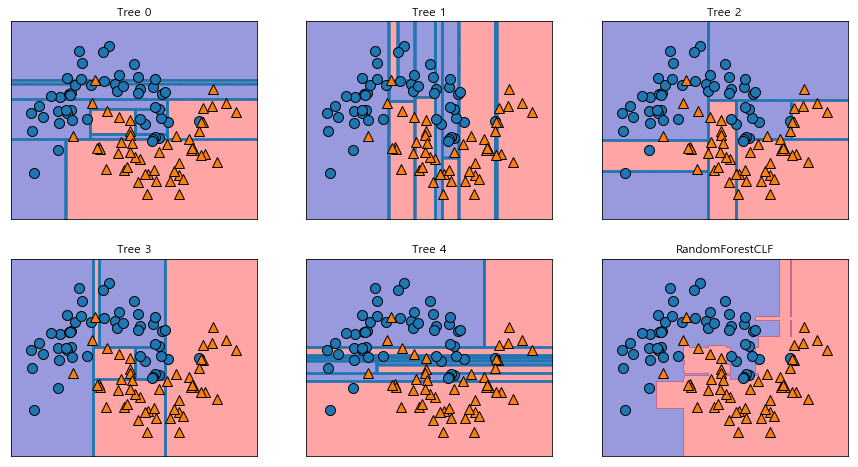

In [109]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# RandomForest Tree의 각 estimator를 출력
for i, (ax, tree) in enumerate(zip(axes.ravel(), rf_clf.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
# RandomForest Tree의 결정 경계를 출력
mglearn.plots.plot_2d_separator(rf_clf, Xm ,fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("RandomForestCLF")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

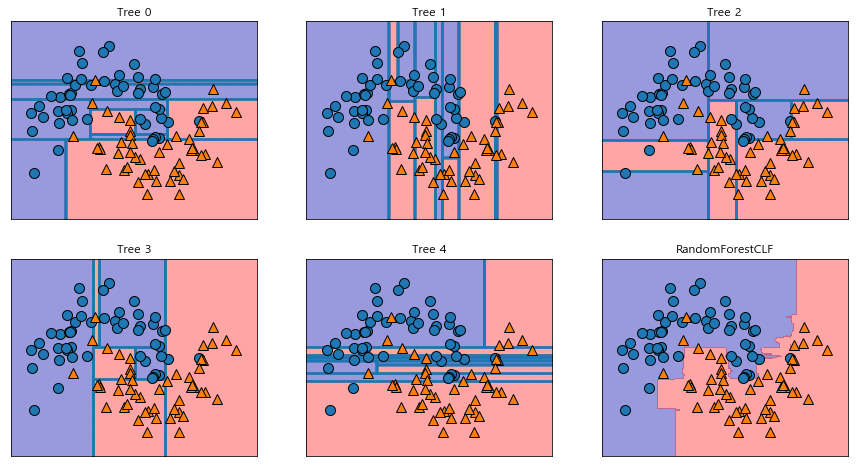

In [105]:
# n_estimator를 늘려서 재출력

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# RandomForest Tree의 각 estimator를 출력
for i, (ax, tree) in enumerate(zip(axes.ravel(), rf_clf.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
    
# 재 학습
rf_clf = RandomForestClassifier(n_estimators=2000, 
                                n_jobs=-1, random_state=42)
rf_clf.fit(Xm_train, ym_train)

mglearn.plots.plot_2d_separator(rf_clf, Xm ,fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("RandomForestCLF")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

### 다른 시각화

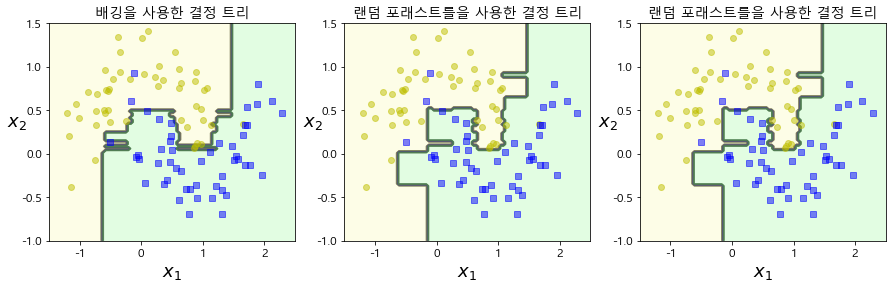

In [114]:
# n_estimators = 5
Xm, ym = make_moons(n_samples=100, noise=.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    Xm, ym, stratify=ym, random_state=42)

bagging = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=5,
        n_jobs=-1, random_state=42)
bagging.fit(Xm_train, ym_train)

rf_clf = RandomForestClassifier(n_estimators=5, 
                                n_jobs=-1, random_state=42)
rf_clf.fit(Xm_train, ym_train)

# max_features = 1
rf_clf2 = RandomForestClassifier(n_estimators=5, max_features=1,
                                n_jobs=-1, random_state=42)
rf_clf2.fit(Xm_train, ym_train)

# 시각화
plt.figure(figsize=(15,4))
plt.subplot(131)
plot_decision_boundary(bagging, Xm, ym)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.subplot(132)
plot_decision_boundary(rf_clf, Xm, ym)
plt.title("랜덤 포래스트를을 사용한 결정 트리", fontsize=14)
plt.subplot(133)
# 똑같다!! max_featuer's default == auto, sqrt(num_features) = sqrt(2) == 1
plot_decision_boundary(rf_clf2, Xm, ym)
plt.title("랜덤 포래스트를을 사용한 결정 트리", fontsize=14)
plt.show()

### Feature Importance

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
iris = load_iris()
rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf_clf.fit(iris.data, iris.target)
for name, importance in zip(iris['feature_names'], rf_clf.feature_importances_):
    print(name, "= {:4f}".format(importance))

sepal length (cm) = 0.112492
sepal width (cm) = 0.023119
petal length (cm) = 0.441030
petal width (cm) = 0.423358


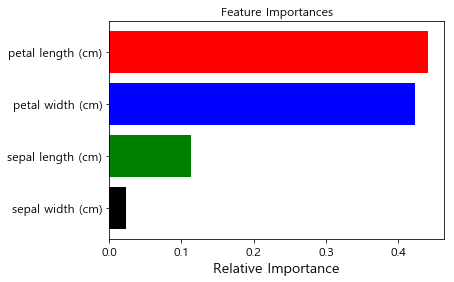

In [34]:
features= iris['feature_names']
importances = rf_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color=['k','g','b','r'], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 5-3 Boosting

### 부스팅
- weak learner로 잘못 분류된 경우의 가중치를 증가시켜서 점차 분류해 나가는 기법
- 출처 : http://uc-r.github.io/gbm_regression
- 부스팅의 아이디어
    -Sequential하게 모델을 훈련시키자!
![title](http://uc-r.github.io/public/images/analytics/gbm/boosted-trees-process.png)

### AdaBoost
- 자주 잘못 분류되는 예제에 좀 더 가중치를 두어 학습
- 좀 더 큰 비율로 반복 학습하는 weak learner를 생성해서 결론은 뽑는 기법
- 역시 tree 기반이지만, RandomForest와 달리 tree들이 독립적으로 존재하지는 않음

>### 의사결정 스텀프로 weak 학습기 생성하기
- 의사결정 스텀프 : 모 아니면 도, 하나의 속성에 대한 것을 의미
- 간단한 의사결정 트리
- 하나의 속성에 대한 하나의 의사결정을 만드는 것
- 단지 하나의 분할을 가지는 트리이며 이것이 곧 하나의 스텀프

In [124]:
def load_simp_data():
    data_mat = np.mat(
            [[1., 2.1],
             [2, 1.1],
             [1.3, 1.],
             [1., 1.],
             [2., 1.]])
    class_label = [1., 1., -1., -1., 1.]
    return data_mat, class_label

In [125]:
data_mat, class_label = load_simp_data()

In [126]:
class_label

[1.0, 1.0, -1.0, -1.0, 1.0]

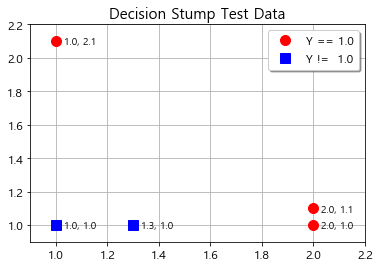

In [253]:
y_1 = np.where(np.array(class_label) == 1.0)[0]
y_m1 = np.where(np.array(class_label) != 1.0)[0]
plt.plot(data_mat[y_1][:, 0], data_mat[y_1][:, 1], marker='o', ls='',
        label='Y == 1.0', markersize=10, color='r')
plt.plot(data_mat[y_m1][:, 0], data_mat[y_m1][:, 1], marker='s', ls='',
        label='Y !=  1.0', markersize=10, color='b')
for pt in data_mat:
    x, y = pt[0,0], pt[0,1]
    txt = str(x) + ', ' + str(y)
    plt.text(x=x+.03, y=y-.02, s=txt)
plt.axis([.9, 2.2, .9, 2.2])
plt.grid(True)
plt.legend(shadow=True, fontsize=12)
plt.title('Decision Stump Test Data', fontsize=15)
plt.show()

- 위의 분류 문제를 Decision Tree로 해결하기 어려움

>### 의사결정 스텀프 생성 함수
```
Set the minError to +inf
// +inf를 위해 minError를 설정
For every feature in the dataset:
// 데이터 집합에 있는 모든 속성을 반복
    For every step:
    // 모든 단계를 반복
        For each inequality:
        // 각각에 대해 부등호를 반복
            Build a decision stump and test it with the weighted dataset
            // 의사결정 스텀프를 구축하고, 가중치가 부여된 데이터 집합을 검사
            if the error is less than minError:
                set this stump as the best stump
            // 오류가 minError보다 작으면, 이 스텀프를 가장 좋은 스텀프로 설정
Return the best stump
// 가장 좋은 스텀프 반환
```

In [337]:
def stump_classify(data_mat, dim, thresh, thresh_lneq): # just classify the data
    ret_arr = np.ones((data_mat.shape[0], 1))
    if thresh_lneq == 'lt':
        ret_arr[data_mat[:, dim] <= thresh] = -1.
    else:
        ret_arr[data_mat[:, dim] > thresh] = -1.
    return ret_arr

def build_stump(data_arr, class_label, D, silent=False):
    data_mat, label_mat = np.mat(data_arr), np.mat(class_label).T
    m, n = np.shape(data_mat)
    num_steps = 10.; best_stump = {}; best_class_est = np.mat(np.zeros((m, 1)))
    min_err = np.inf # init error sum, to _infinity
    for i in range(n): # loop over all dimensions
        range_min, range_max = data_mat[:, i].min(), data_mat[:, i].max()
        step_size = (range_max - range_min) / num_steps
        for j in range(-1, int(num_steps) + 1): # loop iver all range in current dimension
            for inequal in ['lt', 'gt']: # go over less than and greater than
                thresh = (range_min + float(j) * step_size)
                # call stump classify with i, j, lessThan
                predicted_value = stump_classify(data_mat, i, thresh, inequal)
                err_arr = np.mat(np.ones((m, 1)))
                err_arr[predicted_value == label_mat] = 0
                weighted_err = D.T * err_arr # calc total error multiplied by D
                if not silent:
                    print("split : dim {} thersh {:.3f}, \
                        thresh inequal : {}, the weighted error is {}"\
                     .format(i, thresh, inequal, weighted_err))
                if weighted_err < min_err:
                    min_err = weighted_err
                    best_class_est = predicted_value.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh
                    best_stump['ineq'] = inequal
    return best_stump, min_err, best_class_est

In [215]:
D = np.mat(np.ones((5, 1)) / 5)
build_stump(data_mat, class_label, D)

split : dim 0 thersh 0.900,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 0.900,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.000,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.000,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.100,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.100,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.200,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.200,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.300,                     thresh inequal : lt, the weighted error is [[0.2]]
split : dim 0 thersh 1.300,                     thresh inequal : gt, the weighted error is [[0.8]]
split : di

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

>### 의사결정 스텀프로 AdaBoost 학습 구현
    For each iteration:
        Find the best stump using buildStump()
        // 가장 좋은 스텀프 착지
        Add the best stump to the stump array
        // 스텀프 배열에 가장 좋은 스텀프 추가
        Calculate alpha
        // 알파 계산
        Calculate the new weight vector - D
        // 새로운 가중치 벡터 D 계산
        Update the aggregate calss estimate
        // 집계된 분류 항목의 추정치를 계산
        if the error rate == 0.0:
            break out of the for loop
        // 오류율이 0.0이면 반복문 종료

In [216]:
def adaBoostTrainDS(data_arr, class_label, num=40):
    weak_class_arr = []
    m = data_arr.shape[0]
    D = np.mat(np.ones((m, 1)) / m) # init D to all equal
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(num):
        best_stump, err, class_est = build_stump(data_arr, class_label, D) # build Stump
        print("D : {}".format(D.T))
        # calc alpha, throw in max(error, eps) to account for error=0
        alpha = float(.5 * np.log((1. - err) / max(err, 1e-16)))
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump) # store stump params in Array
        print('classEst: {}'.format(class_est.T))
        # exponent for 0 calc, getting messy
        expon = np.multiply(-1 * alpha * np.mat(class_label).T, class_est)
        D = np.multiply(D, np.exp(expon)) # calc new D for next iteration
        D = D / D.sum()
        # calc training error of all calssifies,
        # if this is 0 quit for loop early (use break)
        agg_class_est += alpha * class_est
        print('aggClassEst: {}'.format(agg_class_est.T))
        agg_err = np.multiply(np.sign(agg_class_est) != np.mat(class_label).T, np.ones((m, 1)))
        error_rate = agg_err.sum() / m
        print('total error: {}'.format(error_rate))
        if error_rate == 0.:
            break
    return weak_class_arr

In [218]:
clf_arr = adaBoostTrainDS(data_mat, class_label, 9)
clf_arr

split : dim 0 thersh 0.900,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 0.900,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.000,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.000,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.100,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.100,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.200,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.200,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.300,                     thresh inequal : lt, the weighted error is [[0.2]]
split : dim 0 thersh 1.300,                     thresh inequal : gt, the weighted error is [[0.8]]
split : di

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

>### 의사결정 스텀프로 AdaBoost 검사 구현

In [243]:
def adaClassify(dat_to_class, clf_arr):
    # do stuff similar to last aggClassEst in adaBoostTrainDS
    data_mat = np.mat(dat_to_class)
    m = data_mat.shape[0]
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(len(clf_arr)):
        dim, thresh, lneq, alpha = clf_arr[i].values()
        class_est = stump_classify(data_mat,
                                   dim, thresh, lneq)
        agg_class_est += alpha * class_est
        print(agg_class_est)
    return np.sign(agg_class_est)

In [244]:
clf_arr = adaBoostTrainDS(data_mat, class_label, 30)

split : dim 0 thersh 0.900,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 0.900,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.000,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.000,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.100,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.100,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.200,                     thresh inequal : lt, the weighted error is [[0.4]]
split : dim 0 thersh 1.200,                     thresh inequal : gt, the weighted error is [[0.6]]
split : dim 0 thersh 1.300,                     thresh inequal : lt, the weighted error is [[0.2]]
split : dim 0 thersh 1.300,                     thresh inequal : gt, the weighted error is [[0.8]]
split : di

In [379]:
clf_arr

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

In [380]:
[(i['dim'], i['thresh'], i['ineq']) for i in clf_arr]

[(0, 1.3, 'lt'), (1, 1.0, 'lt'), (0, 0.9, 'lt')]

In [435]:
x1s = np.linspace(.8, 2.2, 100)
x2s = np.linspace(.8, 2.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]

In [450]:
res = np.zeros((X_new.shape[0], 1))

In [451]:
res + (X_new[:, 0] < 1.3).reshape(-1,1)

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [539]:
def decision_boundary(X_new, clf_arr):
    res = np.zeros((X_new.shape[0], 1))
    num = len(clf_arr)
    for standard in clf_arr:
        dim, thresh, ineq = standard
        if ineq == 'lt':
            res += (X_new[:, dim] < thresh).reshape(-1, 1)
        else:
            res += (X_new[:, dim] >= thresh).reshape(-1, 1)
    return np.where(res >= (num - 1), 1, 0).reshape(-1,)

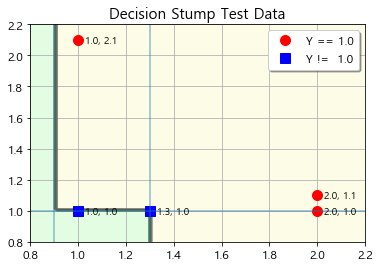

In [557]:
# contour과 contourf함수 기억하자!!

y_1 = np.where(np.array(class_label) == 1.0)[0]
y_m1 = np.where(np.array(class_label) != 1.0)[0]
plt.plot(data_mat[y_1][:, 0], data_mat[y_1][:, 1], marker='o', ls='',
        label='Y == 1.0', markersize=10, color='r')
plt.plot(data_mat[y_m1][:, 0], data_mat[y_m1][:, 1], marker='s', ls='',
        label='Y !=  1.0', markersize=10, color='b')
for pt in data_mat:
    x, y = pt[0,0], pt[0,1]
    txt = str(x) + ', ' + str(y)
    plt.text(x=x+.03, y=y-.02, s=txt)

x1s = np.linspace(.8, 2.2, 100)
x2s = np.linspace(.8, 2.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)
X_new = np.c_[x1.ravel(), x2.ravel()]
for pt in [(i['dim'], i['thresh'], i['ineq']) for i in clf_arr]:
    if pt[0] == 0:
        plt.axvline(pt[1], alpha=.5)
    else:
        plt.axhline(pt[1], alpha=.5)

res = decision_boundary(X_new, 
                        [(i['dim'], i['thresh'], i['ineq']) for i in clf_arr])
y_pred = res.reshape(x1.shape)
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
plt.contourf(x1, x2, y_pred, cmap=custom_cmap, alpha=0.3)
custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
plt.axis([.8, 2.2, .8, 2.2])
plt.grid(True)
plt.legend(shadow=True, fontsize=12)
plt.title('Decision Stump Test Data', fontsize=15)
plt.show()

In [245]:
adaClassify([0,0], clf_arr)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

### Understanding AdaBoost Implement Code

```
def stump_classify(data_mat, dim, thresh, thresh_lneq):
    """
    data_mat : numpy matrix obj.
    dim : dimension
    thresh : threshold
    thresh_lneq : less than or more than
    """
    ret_arr = np.ones((data_mat.shape[0], 1))
    if thresh_lneq == 'lt':
        ret_arr[data_mat[:, dim] <= thresh] = -1.
    else:
        ret_arr[data_mat[:, dim] > thresh] = -1.
    return ret_arr
```

In [254]:
data_mat

matrix([[1. , 2.1],
        [2. , 1.1],
        [1.3, 1. ],
        [1. , 1. ],
        [2. , 1. ]])

In [256]:
# 동일한 instance의 갯수를 가지는 원소가 모두 1인 열벡터 생성
ret_arr = np.ones((data_mat.shape[0], 1))
ret_arr

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [259]:
thresh = 1.3
thresh_lneq= 'lt'
# lneq가 lt(less than)일 경우,
# 특정 임계점보다 data_mat dim열의 값이 작은 부분을 -1로 채우고
# 아닐 경우 큰 부분을 -1로 채움
if thresh_lneq == 'lt':
    ret_arr[data_mat[:, dim] <= thresh] = -1.
else:
    ret_arr[data_mat[:, dim] > thresh] = -1.
    
# stump_classify 함수는 ret_arr을 반환함
ret_arr

array([[-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.]])

```
def build_stump(data_arr, class_label, D):
    data_mat, label_mat = np.mat(data_arr), np.mat(class_label).T
    m, n = np.shape(data_mat)
    num_steps = 10.; best_stump = {}; best_class_est = np.mat(np.zeros((m, 1)))
    min_err = np.inf # init error sum, to _infinity
    for i in range(n): # loop over all dimensions
        range_min, range_max = data_mat[:, i].min(), data_mat[:, i].max()
        step_size = (range_max - range_min) / num_steps
        for j in range(-1, int(num_steps) + 1): # loop iver all range in current dimension
            for inequal in ['lt', 'gt']: # go over less than and greater than
                thresh = (range_min + float(j) * step_size)
                # call stump classify with i, j, lessThan
                predicted_value = stump_classify(data_mat, i, thresh, inequal)
                err_arr = np.mat(np.ones((m, 1)))
                err_arr[predicted_value == label_mat] = 0
                weighted_err = D.T * err_arr # calc total error multiplied by D
                print("split : dim {} thersh {:.3f}, \
                    thresh inequal : {}, the weighted error is {}"\
                     .format(i, thresh, inequal, weighted_err))
                if weighted_err < min_err:
                    min_err = weighted_err
                    best_class_est = predicted_value.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh
                    best_stump['ineq'] = inequal
    return best_stump, min_err, best_class_est
```

In [313]:
# input 설정
D = np.mat(np.ones((5, 1)) / 5) # D : weighted vector, it is same weight
# data와 label을 matrix로 형변환
data_mat, label_mat = np.mat(data_mat), np.mat(class_label).T
print(data_mat)
print(label_mat)

[[1.  2.1]
 [2.  1.1]
 [1.3 1. ]
 [1.  1. ]
 [2.  1. ]]
[[ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [314]:
# return data_mat's shape
m, n = np.shape(data_mat)
print('m & n :', m, n)

m & n : 5 2


In [315]:
# base setting
num_steps = 10.
best_stump = {}
best_class_est = np.mat(np.zeros((m, 1)))
min_err = np.inf

best_class_est

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [316]:
# loop all dimension
## first loop in n == 2, i=0 or 1
i = 0
# data_mat 0열의 min과 max를 반환
range_min, range_max = data_mat[:, i].min(), data_mat[:, i].max()
# range(min, max)을 최초 설정한 num_steps=10으로 나눠서 step_size를 결정
step_size = (range_max - range_min) / num_steps

range_min, range_max, step_size # (2 -1 ) / 10

(1.0, 2.0, 0.1)

In [317]:
# inner loop, num_steps + 1번 loop이 돌음 (-1부터 10까지)
for j in range(-1, int(num_steps) + 1): # loop iver all range in current dimension
    print(j)

-1
0
1
2
3
4
5
6
7
8
9
10


In [318]:
j = -1
# inequal == less than & greater than
## first, we use less than
inequal = 'lt'

thresh = (range_min + float(j) * step_size)
print('thresh : ', thresh) # 1 + (-1 * .1)

# ret_arr 반환
predicted_value = stump_classify(data_mat, i, thresh, inequal)
print('\nret_arr (with thresh:{}, inequal:{})\n'.format(thresh, inequal), predicted_value)
print('\nthresh == .9보다 작은 data_mat의 원소가 없기에 원소가 전부 1인 ret_arr 반환')

# round별 error를 담을 휘발성 err_arr생성
err_arr = np.mat(np.ones((m, 1)))
# 맞춘 부분은 원소를 0으로
err_arr[predicted_value == label_mat] = 0
print('\nD.T : \n', D.T)
print('\nerr_arr : \n', err_arr)
weighted_err = D.T * err_arr # calc total error multiplied by D
print('\nweighted_err(D.T * err_arr) : \n', weighted_err)
print("\nsplit : dim {} thersh {:.3f}, \
    thresh inequal : {}, the weighted error is {}"\
     .format(i, thresh, inequal, weighted_err))
# 새로 계산한 error가 설정한 min_err보다 작을 경우
#  min_err를 새로운 error로 초기화시키고
# best_class_est에 예측한 정답 레이블을 저장,
# best_stump에 dim, thresh, ineq를 저장시킴
if weighted_err < min_err:
    min_err = weighted_err
    best_class_est = predicted_value.copy()
    best_stump['dim'] = i
    best_stump['thresh'] = thresh
    best_stump['ineq'] = inequal
    print('\nmin_err가 update됬습니다.', min_err)
else:
    print('\nmin_err가 update되지 않았습니다.', min_err)
print('\n현재까지 최고 예측 결과는 다음과 같습니다 :\n', best_class_est)
print('\n최고 예측 parameter는 다음과 같습니다.', best_stump)

thresh :  0.9

ret_arr (with thresh:0.9, inequal:lt)
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]

thresh == .9보다 작은 data_mat의 원소가 없기에 원소가 전부 1인 ret_arr 반환

err_arr : 
 [[0.]
 [0.]
 [1.]
 [1.]
 [0.]]

D : 
 [[0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.2]]

weighted_err(D.T * err_arr) : 
 [[0.4]]

split : dim 0 thersh 0.900,     thresh inequal : lt, the weighted error is [[0.4]]

min_err이 update됬습니다. [[0.4]]

현재까지 최고 예측 결과는 다음과 같습니다 :
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]

최고 예측 parameter는 다음과 같습니다. {'dim': 0, 'thresh': 0.9, 'ineq': 'lt'}


In [351]:
# inner loop을 함수로 만들어 첫번째 열 (i==0)에서의 결과를 출력해보자
def inner_loop_i_is_0(i, data_mat=data_mat, class_label=class_label, 
                      D=D, num_steps=10, min_err=np.inf, best_stump={},
                      best_class_est = np.mat(np.zeros((m, 1)))):
    range_min, range_max = data_mat[:, i].min(), data_mat[:, i].max()
    step_size = (range_max - range_min) / num_steps
    print('{} 열의 loop을 돌겠습니다.'.format(i))
    for j in range(-1, int(num_steps) + 1):
        print('{}번째 스탭 진행중'.format(j))
        for inequal in ['lt', 'gt']:
            thresh = (range_min + float(j) * step_size)
            predicted_value = stump_classify(data_mat, i, thresh, inequal)
            print('ret_arr (with thresh:{}, inequal:{})\n'.format(thresh, inequal), predicted_value)
            err_arr = np.mat(np.ones((m, 1)))
            err_arr[predicted_value == label_mat] = 0
            weighted_err = D.T * err_arr # calc total error multiplied by D
            print("split : dim {} thersh {:.3f}, thresh inequal : {}, the weighted error is {}"\
                 .format(i, thresh, inequal, weighted_err))
            if weighted_err < min_err:
                min_err = weighted_err
                best_class_est = predicted_value.copy()
                best_stump['dim'] = i
                best_stump['thresh'] = thresh
                best_stump['ineq'] = inequal
                print('min_err가 update됬습니다.', min_err)
            else:
                print('min_err가 update되지 않았습니다.', min_err)
            print('현재까지 최고 예측 결과는 다음과 같습니다 :\n', best_class_est)
            print('최고 예측 parameter는 다음과 같습니다.', best_stump)
            print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
    print('\n\n------------------------------------------------------------------------\n\n')
    return min_err, best_class_est, best_stump

In [352]:
min_err, best_class_est, best_stump = inner_loop_i_is_0(i=0)
# 첫번째 열에서
## 3번째 스탭에서 update!
## split : dim 0 thersh 1.300, thresh inequal : lt, the weighted error is [[0.2]]
## .4 -> .2로 줄어들음
## 이후 변동없음

min_err, best_class_est, best_stump = inner_loop_i_is_0(i=1, 
                            min_err=min_err, best_stump=best_stump, best_class_est = best_class_est)
# 두번째 열에서
## 한번도 updqte되지 않음

0 열의 loop을 돌겠습니다.
-1번째 스탭 진행중
ret_arr (with thresh:0.9, inequal:lt)
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
split : dim 0 thersh 0.900, thresh inequal : lt, the weighted error is [[0.4]]
min_err가 update됬습니다. [[0.4]]
현재까지 최고 예측 결과는 다음과 같습니다 :
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
최고 예측 parameter는 다음과 같습니다. {'dim': 0, 'thresh': 0.9, 'ineq': 'lt'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
ret_arr (with thresh:0.9, inequal:gt)
 [[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
split : dim 0 thersh 0.900, thresh inequal : gt, the weighted error is [[0.6]]
min_err가 update되지 않았습니다. [[0.4]]
현재까지 최고 예측 결과는 다음과 같습니다 :
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
최고 예측 parameter는 다음과 같습니다. {'dim': 0, 'thresh': 0.9, 'ineq': 'lt'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
0번째 스탭 진행중
ret_arr (with thresh:1.0, inequal:lt)
 [[-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]]
split : dim 0 thersh 1.000, thresh inequal : lt, the weighted error is [[0.4]]
min_err가 update되지 않았습니다. [[0.4]]
현재까지 최고 예측 결과는 다음과 같습니다 :
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]]

In [344]:
# 위 결과는 전체 함수로 돌린 결과와 동일
D = np.mat(np.ones((5, 1)) / 5)
dicts, err, ret_arr = build_stump(data_mat, class_label, D, silent=True)
print('min_error :', err)
print('현재까지 최고 예측 결과 :\n', ret_arr)
print('최고 예측 parameter :', dicts)

min_error : [[0.2]]
현재까지 최고 예측 결과 :
 [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]
최고 예측 parameter : {'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}


$${y}_{j}^{(i)}\neq{y_{j}^{(i)}}$$

- j번째 예측기의 가중치가 적용된 에러율
$$r_j\,=\,{{\sum_{i=1}^{m}w^{(i)}\;\;\text{if}\;\hat{y}_{j}^{(i)}\neq{y_{j}^{(i)}}}\over{\sum_{i=1}^{m}w^{(i)}}}$$

$$\text{if}\,j=0,\;then\,each\,w^{(i)}={1\over{m}}$$
- 예측기 가중치
$$\alpha_j\,=\,\eta{log{{1-r_j}\over{r_j}}}$$
- 가중치 업데이트 규칙
$$w^{(i)} = \begin{cases}
  w^{(i)}, & \text{if } {y}_{j}^{(i)}={y_{j}^{(i)}}, \\
  w^{(i)}\text{exp}(\alpha_{j}), & \text{otherwise}.
\end{cases}$$
- 아다부스트 예측
$$\hat{y}(X)=\underset{k}{argmax}\sum_{\underset{\hat{y}_{j}(x)=k}{i=1}}^{N}\alpha_{j}$$

```
def adaBoostTrainDS(data_arr, class_label, num=40):
    weak_class_arr = []
    m = data_arr.shape[0]
    D = np.mat(np.ones((m, 1)) / m) # init D to all equal
    agg_class_est = np.mat(np.zeros((m, 1)))
    for i in range(num):
        best_stump, err, class_est = build_stump(data_arr, class_label, D) # build Stump
        print("D : {}".format(D.T))
        # calc alpha, throw in max(error, eps) to account for error=0
        alpha = float(.5 * np.log((1. - err) / max(err, 1e-16)))
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump) # store stump params in Array
        print('classEst: {}'.format(class_est.T))
        # exponent for 0 calc, getting messy
        expon = np.multiply(-1 * alpha * np.mat(class_label).T, class_est)
        D = np.multiply(D, np.exp(expon)) # calc new D for next iteration
        D = D / D.sum()
        # calc training error of all calssifies,
        # if this is 0 quit for loop early (use break)
        agg_class_est += alpha * class_est
        print('aggClassEst: {}'.format(agg_class_est.T))
        agg_err = np.multiply(np.sign(agg_class_est) != np.mat(class_label).T, np.ones((m, 1)))
        error_rate = agg_err.sum() / m
        print('total error: {}'.format(error_rate))
        if error_rate == 0.:
            break
    return weak_class_arr
```

In [613]:
# input setting
num = 40

# function init setting before for-loop
weak_class_arr = []
m = data_mat.shape[0]
D = np.mat(np.ones((m, 1)) / m) # init D to all equal
agg_class_est = np.mat(np.zeros((m, 1)))

print(m, end='\n\n')
print(D, end='\n\n')
print(agg_class_est, end='\n\n')

5

[[0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.2]]

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]



In [614]:
# 초기에 argument로 넘긴 n만큼 loop을 돌음
# 최초 index 0으로 시작
i = 0

# build_stump 함수로
## 오차가 최소일 때 dim, thresh, ineq 값,
## 그 때의 오차 min_error, 그리고
## 그 떄의 label class_est를 return
best_stump, err, class_est = build_stump(data_mat, class_label, D, silent=True) # build Stump

# 매 epoch마다 결정된 weight를 update할 것이기 때문에 D를 출력 
print("D : {}".format(D.T))

# alpha = .5 * log(odds(err))로 계산
alpha = float(.5 * np.log((1. - err) / max(err, 1e-16)))

# 데이터 포인터를 돌면서 오차를 최소로 하며 학습한 결과 best_stump에 alpha값을 저장
best_stump['alpha'] = alpha

# weak_class_arr에 alpha값이 추가된 best_stump를 저장
weak_class_arr.append(best_stump)

# 오차가 최소일 때의 label class를 출력
print('class_est: {}'.format(class_est.T))

# exponent for 0 calc, getting messy
print('-alpha * class_label :\n', -1 * alpha * np.mat((class_label)).T)
print('class_est :\n', class_est)

D : [[0.2 0.2 0.2 0.2 0.2]]
class_est: [[-1.  1. -1. -1.  1.]]
-alpha * class_label :
 [[-0.69314718]
 [-0.69314718]
 [ 0.69314718]
 [ 0.69314718]
 [-0.69314718]]
class_est :
 [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [615]:
class_label # 실제 라벨

[1.0, 1.0, -1.0, -1.0, 1.0]

#### odds
$$odds={{1-p}\over{p}}$$

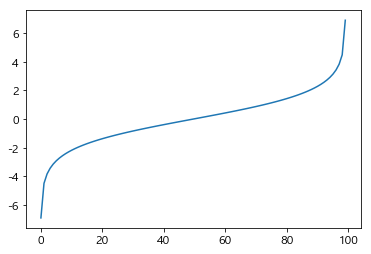

In [616]:
p = 1e-3
plt.plot(
    -np.log((1 - np.linspace(p, 1-p, 100)) / np.linspace(p, 1-p, 100))
)

In [617]:
(1 - np.linspace(1e-6, 1, 100)) / np.linspace(1e-6, 1, 100)

array([9.99999000e+05, 9.79902990e+01, 4.84975994e+01, 3.19989440e+01,
       2.37494122e+01, 1.87996278e+01, 1.54997443e+01, 1.31426713e+01,
       1.13748592e+01, 9.99989000e+00, 8.89991189e+00, 7.99992800e+00,
       7.24994019e+00, 6.61533424e+00, 6.07138564e+00, 5.59996304e+00,
       5.18746790e+00, 4.82350132e+00, 4.49997525e+00, 4.21050438e+00,
       3.94998045e+00, 3.71426820e+00, 3.49998425e+00, 3.30433360e+00,
       3.12498711e+00, 2.95998828e+00, 2.80768162e+00, 2.66665689e+00,
       2.53570532e+00, 2.41378486e+00, 2.29999241e+00, 2.19354138e+00,
       2.09374352e+00, 1.99999400e+00, 1.91175914e+00, 1.82856626e+00,
       1.74999519e+00, 1.67567119e+00, 1.60525898e+00, 1.53845763e+00,
       1.47499635e+00, 1.41463073e+00, 1.35713966e+00, 1.30232258e+00,
       1.24999719e+00, 1.19999736e+00, 1.15217143e+00, 1.10638065e+00,
       1.06249781e+00, 1.02040610e+00, 9.79998060e-01, 9.41174644e-01,
       9.03844433e-01, 8.67922907e-01, 8.33331806e-01, 7.99998560e-01,
      

In [618]:
class_est # 내가 예측한 값`

array([[-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.]])

In [619]:
-1 * alpha * np.mat(class_label).T # 실제 클래스 * alpha(error의 odds)

matrix([[-0.69314718],
        [-0.69314718],
        [ 0.69314718],
        [ 0.69314718],
        [-0.69314718]])

In [620]:
expon = np.multiply(-1 * alpha * np.mat(class_label).T, class_est)
expon

matrix([[ 0.69314718],
        [-0.69314718],
        [-0.69314718],
        [-0.69314718],
        [-0.69314718]])

In [621]:
expon = np.exp(expon)
expon

matrix([[2. ],
        [0.5],
        [0.5],
        [0.5],
        [0.5]])

In [622]:
D = np.multiply(D, np.exp(expon))
D

matrix([[1.47781122],
        [0.32974425],
        [0.32974425],
        [0.32974425],
        [0.32974425]])

In [623]:
D = D / D.sum()
D

matrix([[0.52839582],
        [0.11790104],
        [0.11790104],
        [0.11790104],
        [0.11790104]])

In [ ]:
# data type이 matrix이기 때문에 elemental-wise 곱연산을 하기 위해 numpy의 multiply함수 사용
# 가중치 업데이트를 위해 weight D에 expon을 곱해줌
expon = np.multiply(-1 * alpha * np.mat(class_label).T, class_est)
print('np.multiply(-alpha * class_label, class_est)', expon)
D = np.multiply(D, np.exp(expon)) # calc new D for next iteration
D = D / D.sum()
# calc training error of all calssifies,
# if this is 0 quit for loop early (use break)
agg_class_est += alpha * class_est
print('aggClassEst: {}'.format(agg_class_est.T))
agg_err = np.multiply(np.sign(agg_class_est) != np.mat(class_label).T, np.ones((m, 1)))
error_rate = agg_err.sum() / m
print('total error: {}'.format(error_rate))
if error_rate == 0.:
    break

### 아다부스팅 시각화

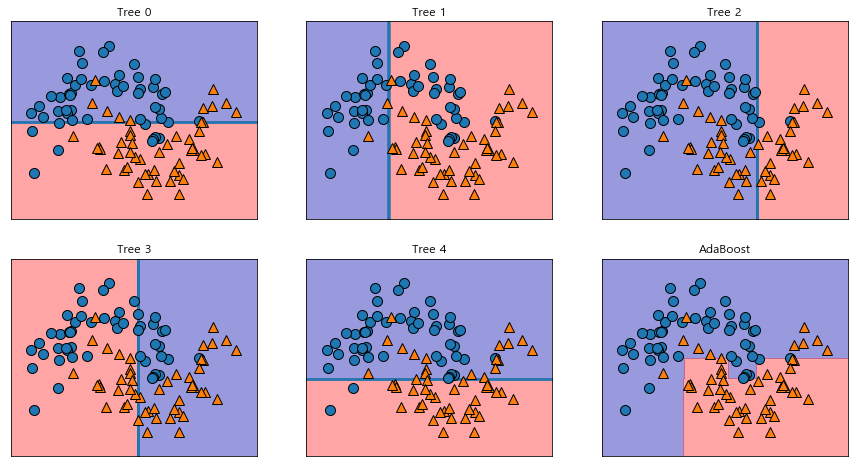

In [247]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=5, random_state=42)
ada.fit(Xm_train, ym_train)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, (ax, tree) in enumerate(zip(axes.ravel(), ada.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(ada, Xm ,fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("AdaBoost")
mglearn.discrete_scatter(Xm[:, 0], Xm[:, 1], ym)
plt.show()

### Two-class AdaBoost
- 출처 : https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html

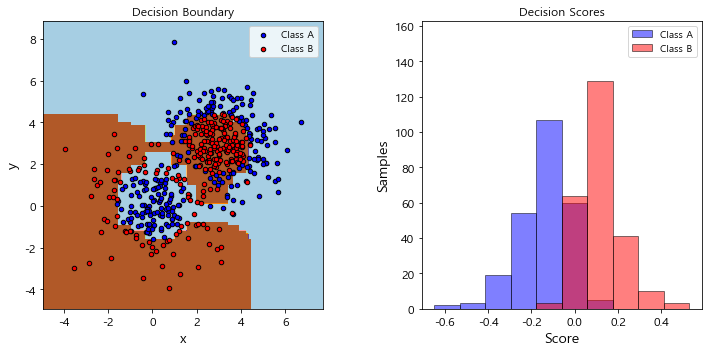

In [246]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles


# Construct dataset
X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()